In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
from scipy.optimize import curve_fit
from scipy.interpolate import CubicSpline

In [6]:
df = pd.read_csv("dataset.csv")

In [6]:
df.describe()

,5.05
count,99.000000
mean,5.011919
std,0.323134
min,3.970000
25%,4.895000
50%,5.030000
75%,5.110000
max,7.140000


In [25]:
def plot_relative_frequency_histogram(data, bins='auto', figsize=(10, 6)):
    def gaussian(x, A, mu, sigma):
        return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

    # Преобразование данных
    if isinstance(data, (pd.Series, pd.DataFrame)):
        data = data.values.flatten()
    data = data[~np.isnan(data)]

    plt.figure(figsize=figsize)

    # ======== ГИСТОГРАММА ОТНОСИТЕЛЬНЫХ ЧАСТОТ ========
    # density=True → высоты столбцов = относительная частота / ширину бина
    n, bin_edges, _ = plt.hist(
        data,
        bins=bins,
        density=True,
        alpha=0.7,
        color='lightblue',
        edgecolor='black',
        label='Относительные частоты'
    )

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width = bin_edges[1] - bin_edges[0]

    # ======== 1. Нормальное распределение по статистике выборки ========
    mu, sigma = np.mean(data), np.std(data)
    x = np.linspace(bin_edges[0], bin_edges[-1], 1000)

    pdf_stats = norm.pdf(x, mu, sigma)

    plt.plot(
        x, pdf_stats,
        'g--', linewidth=2,
        label=f'Нормальное распределение\n(по μ={mu:.2f}, σ={sigma:.2f})'
    )

    # ======== 2. Gaussian Fit ПРЯМО к density-гистограмме ========
    # Fit: A * exp(-(x-mu)^2 / 2 sigma^2)
    # Здесь A будет масштабировать плотность (НЕ высоту столбцов)
    A0 = max(n)
    popt, pcov = curve_fit(
        gaussian,
        bin_centers,
        n,
        p0=[A0, mu, sigma]
    )
    A_hat, mu_hat, sigma_hat = popt

    pdf_fit = gaussian(x, A_hat, mu_hat, sigma_hat)

    plt.plot(
        x, pdf_fit,
        'r-', linewidth=2,
        label=f'Gaussian Fit\n(μ={mu_hat:.2f}, σ={sigma_hat:.2f})'
    )

    # ======== Оформление ========
    #plt.title('Гистограмма относительных частот и кривые нормального распределения', fontsize=14)
    plt.xlabel('Значения')
    plt.ylabel('Плотность вероятности')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()


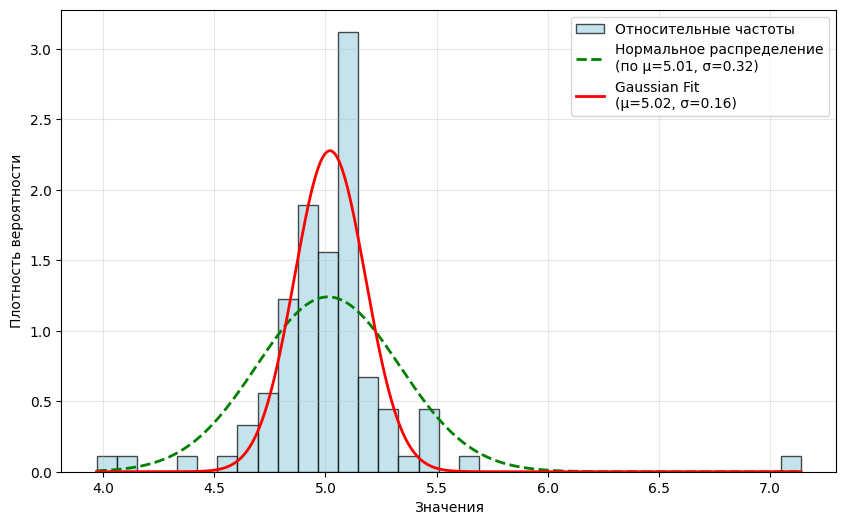

In [26]:
plot_relative_frequency_histogram(df)

In [31]:
def remove_outliers_3sigma(data, sigma_level=3, return_mask=False):
    """
    Удаляет выбросы используя правило n-сигм
    
    Parameters:
    data: массив, Series или список с данными
    sigma_level: количество сигм для границы (по умолчанию 3)
    return_mask: если True, возвращает маску для фильтрации
    
    Returns:
    Очищенные данные или маску
    """
    # Преобразуем в numpy array и удаляем NaN
    if hasattr(data, 'values'):
        data_clean = data.values.flatten()
    else:
        data_clean = np.array(data).flatten()
    
    data_clean = data_clean[~np.isnan(data_clean)]
    
    if len(data_clean) == 0:
        return data_clean if not return_mask else (data_clean, np.array([]))
    
    # Вычисляем параметры распределения
    mu = np.mean(data_clean)
    sigma = np.std(data_clean)
    
    # Границы по правилу n-сигм
    lower_bound = mu - sigma_level * sigma
    upper_bound = mu + sigma_level * sigma
    
    # Создаем маску для данных внутри границ
    mask = (data_clean >= lower_bound) & (data_clean <= upper_bound)
    cleaned_data = data_clean[mask]
    
    print(f"Исходный размер: {len(data_clean)}")
    print(f"Очищенный размер: {len(cleaned_data)}")
    print(f"Удалено выбросов: {len(data_clean) - len(cleaned_data)}")
    print(f"Границы: [{lower_bound:.2f}, {upper_bound:.2f}]")
    print(f"Процент выбросов: {(1 - len(cleaned_data)/len(data_clean))*100:.2f}%")
    
    if return_mask:
        return cleaned_data, mask
    else:
        return cleaned_data

In [32]:
def preprocess_and_visualize(data, sigma_level=3, bins=30, figsize=(15, 10)):
    """
    Полный пайплайн: удаление выбросов + сравнение до/после
    """
    # Очищаем данные
    cleaned_data = remove_outliers_3sigma(data, sigma_level)
    
    # Создаем фигуру с несколькими subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # 1. Исходные данные с гауссовым распределением
    if hasattr(data, 'values'):
        original_data = data.values.flatten()
    else:
        original_data = np.array(data).flatten()
    
    original_data = original_data[~np.isnan(original_data)]
    
    mu_orig, sigma_orig = np.mean(original_data), np.std(original_data)
    
    axes[0, 0].hist(original_data, bins=bins, density=True, alpha=0.7, 
                   color='lightcoral', edgecolor='black', label='Исходные данные')
    
    x_orig = np.linspace(original_data.min(), original_data.max(), 1000)
    y_orig = stats.norm.pdf(x_orig, mu_orig, sigma_orig)
    axes[0, 0].plot(x_orig, y_orig, 'r-', linewidth=2, 
                   label=f'N(μ={mu_orig:.2f}, σ={sigma_orig:.2f})')
    
    # Добавляем границы 3σ
    lower_orig = mu_orig - sigma_level * sigma_orig
    upper_orig = mu_orig + sigma_level * sigma_orig
    axes[0, 0].axvline(lower_orig, color='blue', linestyle='--', alpha=0.7, label=f'±{sigma_level}σ')
    axes[0, 0].axvline(upper_orig, color='blue', linestyle='--', alpha=0.7)
    
    axes[0, 0].set_title('Исходные данные с выбросами', fontsize=12)
    axes[0, 0].set_xlabel('Значения')
    axes[0, 0].set_ylabel('Плотность вероятности')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # 2. Очищенные данные с гауссовым распределением
    mu_clean, sigma_clean = np.mean(cleaned_data), np.std(cleaned_data)
    
    axes[0, 1].hist(cleaned_data, bins=bins, density=True, alpha=0.7, 
                   color='lightgreen', edgecolor='black', label='Очищенные данные')
    
    x_clean = np.linspace(cleaned_data.min(), cleaned_data.max(), 1000)
    y_clean = stats.norm.pdf(x_clean, mu_clean, sigma_clean)
    axes[0, 1].plot(x_clean, y_clean, 'g-', linewidth=2, 
                   label=f'N(μ={mu_clean:.2f}, σ={sigma_clean:.2f})')
    
    axes[0, 1].set_title('Данные после удаления выбросов', fontsize=12)
    axes[0, 1].set_xlabel('Значения')
    axes[0, 1].set_ylabel('Плотность вероятности')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # 3. Box plot сравнение
    box_data = [original_data, cleaned_data]
    axes[1, 0].boxplot(box_data, labels=['С выбросами', 'Без выбросов'])
    axes[1, 0].set_title('Box plot сравнение', fontsize=12)
    axes[1, 0].set_ylabel('Значения')
    axes[1, 0].grid(alpha=0.3)
    
    # 4. QQ-plot для очищенных данных
    stats.probplot(cleaned_data, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot очищенных данных', fontsize=12)
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return cleaned_data

Исходный размер: 99
Очищенный размер: 97
Удалено выбросов: 2
Границы: [4.05, 5.98]
Процент выбросов: 2.02%


/tmp/ipykernel_59496/1868401538.py:60: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1, 0].boxplot(box_data, labels=['С выбросами', 'Без выбросов'])


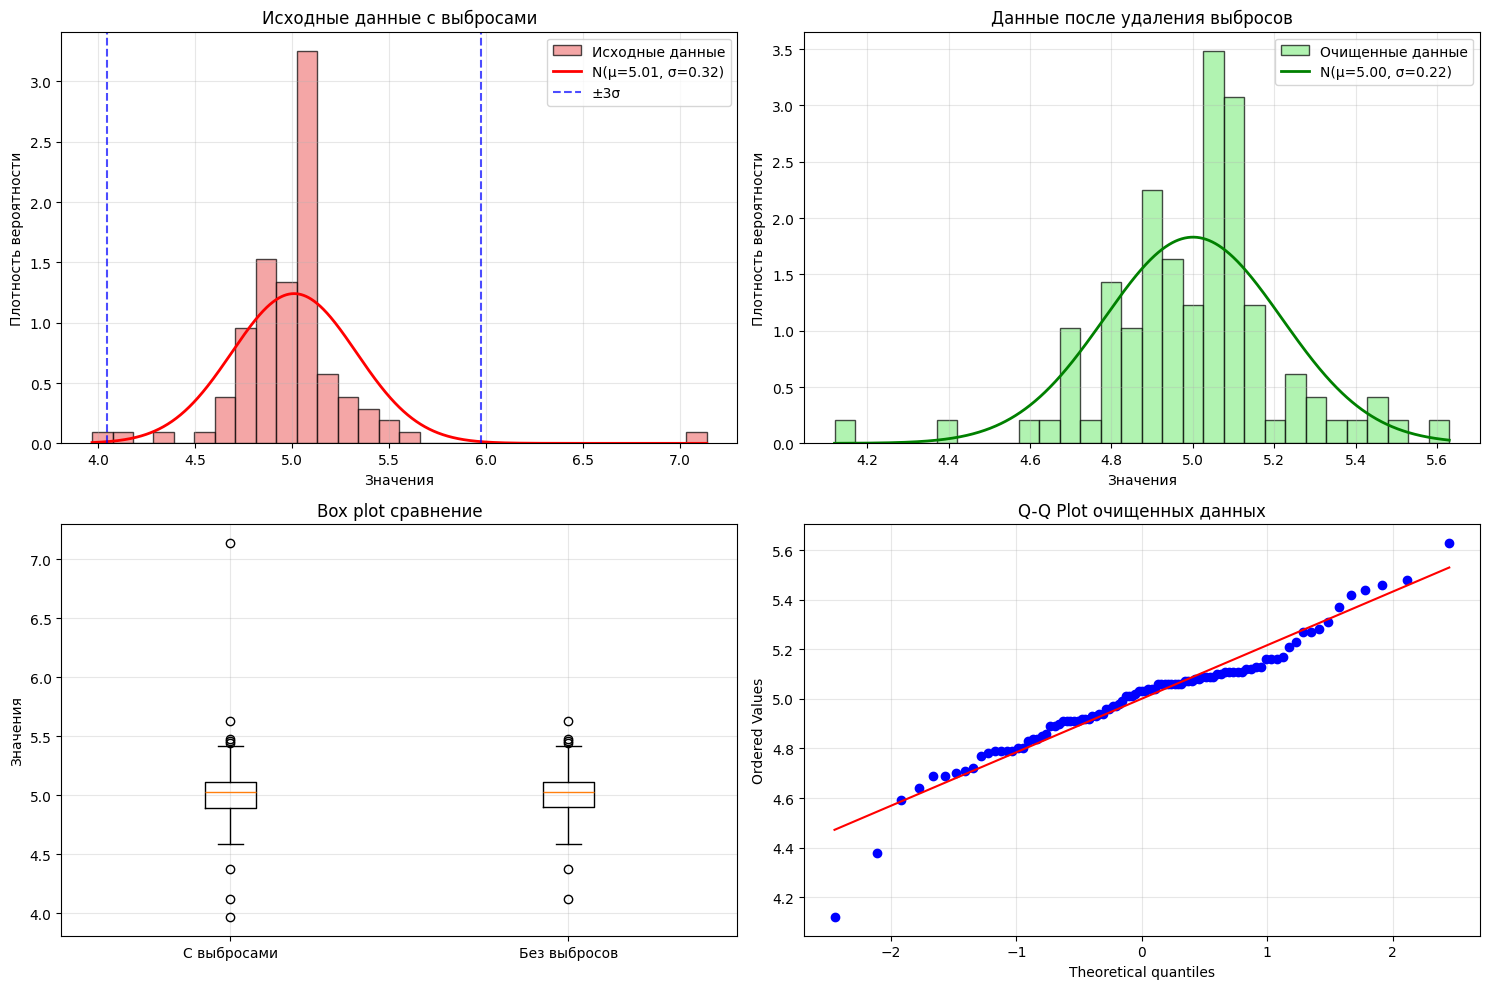

array([5.42, 4.38, 4.7 , 5.1 , 5.28, 4.97, 4.72, 5.23, 5.01, 5.12, 5.08,
       4.91, 5.11, 5.17, 4.69, 5.09, 4.89, 4.89, 4.77, 5.27, 5.01, 5.06,
       4.99, 5.48, 5.46, 4.59, 5.11, 5.04, 5.06, 5.01, 5.09, 5.02, 4.84,
       5.09, 5.07, 4.79, 5.21, 4.92, 4.86, 5.04, 4.97, 5.12, 5.44, 4.85,
       4.69, 4.79, 5.16, 4.12, 5.31, 5.11, 4.79, 5.16, 4.78, 5.16, 4.94,
       4.71, 4.64, 5.63, 5.04, 4.94, 4.91, 5.06, 4.96, 4.84, 5.13, 5.06,
       4.79, 5.06, 4.98, 5.11, 4.96, 5.03, 5.11, 5.37, 4.8 , 5.13, 4.83,
       5.27, 4.8 , 4.93, 4.91, 5.06, 5.07, 5.08, 4.93, 4.92, 5.07, 5.03,
       5.03, 4.91, 5.06, 4.92, 5.06, 4.9 , 5.1 , 4.91, 5.09])

In [33]:
preprocess_and_visualize(df)

In [2]:
def integral_of_gaussian(t1,t2, mu, sigma):
    return stats.norm.cdf(t2, mu, sigma) - stats.norm.cdf(t1, mu, sigma)

In [5]:
t1_list = [4.689, 4.37, 4.05]
t2_list = [5.33, 5.649, 5.97]

mu = 5.01
sigma = 0.32

for a,b in zip(t1_list, t2_list):
    print(integral_of_gaussian(a, b, mu, sigma))

0.6834444691554518
0.9543304862534903
0.9973002039367398


In [9]:
data = df.values.flatten()
data_clean = data[~np.isnan(data)]
n = len(data_clean)

hat_t = 5.01

mu = np.mean(data_clean)
sigma = np.std(data_clean) 

intervals = {
    "1sigma": (hat_t - sigma, hat_t + sigma),
    "2sigma": (hat_t - 2*sigma, hat_t + 2*sigma),
    "3sigma": (hat_t - 3*sigma, hat_t + 3*sigma),
}

results = {}

for name, (t1, t2) in intervals.items():
    mask = (data_clean >= t1) & (data_clean <= t2)
    n_I = np.sum(mask)
    p_I = n_I / n
    results[name] = (n_I, p_I)

results

{'1sigma': (np.int64(87), np.float64(0.8787878787878788)),
 '2sigma': (np.int64(96), np.float64(0.9696969696969697)),
 '3sigma': (np.int64(97), np.float64(0.9797979797979798))}

In [19]:
def measuremenet_uncertainity(data, inst_error, confidence=0.95):
    # Преобразование данных
    if isinstance(data, (pd.Series, pd.DataFrame)):
        data = data.values.flatten()
    data = data[~np.isnan(data)]
    n = len(data)

    x_mean = np.mean(data)
    s = np.std(data, ddof=1)

    s_mean = s / np.sqrt(n)

    # student coef
    t_coef = stats.t.ppf((1 + confidence) / 2, df=n - 1)

    # случайная погрешность
    delta1 = t_coef * s_mean

    # суммарная погршеность
    delta = np.sqrt(delta1 ** 2 + inst_error ** 2)
    return {
        "mean" : x_mean,
        "s" : s,
        "se" : s_mean,
        "delta_random" : delta1,
        "delta_inst" : inst_error,
        "delta_total" : delta
    }

In [20]:
measuremenet_uncertainity(data=df, inst_error=0.01, confidence=0.99)

{'mean': np.float64(5.011919191919192),
 's': np.float64(0.3231341313956322),
 'se': np.float64(0.03247620214535493),
 'delta_random': np.float64(0.0853127452877027),
 'delta_inst': 0.01,
 'delta_total': np.float64(0.08589682478720875)}

In [21]:
measuremenet_uncertainity(data=df, inst_error=0.01, confidence=0.9)

{'mean': np.float64(5.011919191919192),
 's': np.float64(0.3231341313956322),
 'se': np.float64(0.03247620214535493),
 'delta_random': np.float64(0.05392839699743794),
 'delta_inst': 0.01,
 'delta_total': np.float64(0.0548477164767438)}

In [22]:
measuremenet_uncertainity(data=df, inst_error=0.01, confidence=0.7)

{'mean': np.float64(5.011919191919192),
 's': np.float64(0.3231341313956322),
 'se': np.float64(0.03247620214535493),
 'delta_random': np.float64(0.03383847305336207),
 'delta_inst': 0.01,
 'delta_total': np.float64(0.03528515634913796)}